# Finding Similar Songs - Part 2: Siamese Networks

In the first part of this tutorial we have introduced the traditional **distance based approach** to similarity estimations. The main idea is that features are extracted from the audio content. These features are numeric descriptions of semantically relevant information. An example for a high-level feature is the *number of beats per minute* which is a description for the tempo of a song. 

Music **feature-sets** are more abstract and describe the spectral or rhythmical distribution of energy. These are not single but vectors of numbers. Thus, a song is semantically described by this vector and if the set of extracted features spans over various music characteristics such as *rhythm*, *timbre*, *harmonics*, *complexity*, etc. then calculating the similarity of the vector's numbers is considered to be an approximation of **music similarity**. Thus, the lower the numerical distance between two vectors, the higher their acoustic similarity. They mainly depend on the selected sets of features and on the similarity metric chosen to compare their values.

In the second part of this tutorial we are now focussing on an approach, where the feature representation as well as the similarity function is learned from the underlying dataset.

## Requirements

In [52]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

from IPython.display import HTML, display
pd.set_option('display.max_colwidth', -1)

# Deep Learning
from keras.models       import Model
from keras.layers       import Input, Lambda, Dense, Conv2D, Flatten, MaxPooling2D, Concatenate
from keras.layers       import Dropout, BatchNormalization, GaussianNoise
from keras.optimizers   import Nadam, SGD, Adam, RMSprop
from keras.constraints  import unit_norm
from keras.regularizers import l2
from keras import backend as K
import tensorflow as tf

# Machine Learning preprocessing 
from sklearn import preprocessing

<ipython-input-52-2fdcfc6526d2>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Loading Data

Download and extract the dataset on `SPECTROGRAM_PATH`. 

In [53]:
SPECTROGRAM_PATH = '../../../Machine-Learning/ismir2018/ISMIR2018_tut_melspecs_subset'
METADATA_PATH = '../../../Machine-Learning/ismir2018/metadata'
AUDIO_PATH = '../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset'

# here, %s will be replaced by 'genres'
SPECTROGRAM_FILE_PATTERN = os.path.join(SPECTROGRAM_PATH,'ISMIR2018_tut_melspecs_part_1_%s_subset.npz')
LABEL_FILE_PATTERN = os.path.join(METADATA_PATH,'ismir2018_tut_part_1_%s_labels_subset.csv') 

METADATA_FILE = os.path.join(METADATA_PATH,'ismir2018_tut_part_1_genres_metadata_subset.csv')

### Load Feature Data

We already have pre-processed the audio files and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids:

In [54]:
task = 'genres'
SPECTROGRAM_FILE = SPECTROGRAM_FILE_PATTERN % task

npz = np.load(SPECTROGRAM_FILE)
melspecs = npz['features']
clip_id = npz['clip_id']

# check how many spectrograms we have and their dimensions
melspecs.shape

(1998, 80, 80)

In [55]:
# check whether we have the same number of clip ids
len(clip_id)

1998

In [56]:
# create a dataframe that associates the index order of the spectrograms with the clip ids
feature_metadata = pd.DataFrame({'featurespace_id':np.arange(melspecs.shape[0]),
                                 'clip_id'        :clip_id})

# dataframe
feature_metadata

,featurespace_id,clip_id
0,0,41797
1,1,38338
2,2,34335
3,3,25542
4,4,38344
...,...,...
1993,1993,29845
1994,1994,20711
1995,1995,5644
1996,1996,34175


Show a Mel Spectrogram ... just for illustration!!!

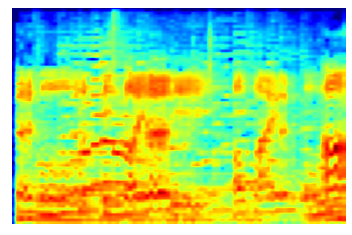

In [57]:
i = 10
spec = melspecs[i]

fig = plt.imshow(spec, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network! (unless we use BatchNormalization in our Neural Network).

Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance).

We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the *scikit-learn* package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first, and then reshape again to the original shape. We created a convenience function for that:

In [58]:
def standardize(data):
    # vectorize before standardization 
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize features by removing the mean and scaling to unit variance
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim)

In [59]:
melspecs = standardize(melspecs)

# verify that the shape is again the same as before
melspecs.shape 

(1998, 80, 80)

Add the layer-dimension to the feature-space (required by the convolutional neural networks). Only one layer added => **mono-channel audio**:

In [60]:
melspecs = np.expand_dims(melspecs, 3)
melspecs.shape 

(1998, 80, 80, 1)

### Load Metadata

In [61]:
metadata = pd.read_csv(METADATA_FILE, index_col=0)
metadata.shape

(1998, 10)

In [62]:
# dataframe
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
19072,41797,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3
17487,38338,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3
15668,34335,D:/Research/Data/MIR/MagnaTagATune/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3
11610,25542,D:/Research/Data/MIR/MagnaTagATune/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3
17489,38344,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3
...,...,...,...,...,...,...,...,...,...,...
13597,29845,D:/Research/Data/MIR/MagnaTagATune/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3
9433,20711,D:/Research/Data/MIR/MagnaTagATune/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.mp3,4,von Biber_ Sonata I in A Major,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/04-von%20Biber_%20Sonata%20I%20in%20A%20Major-Music%20of%20the%20Spheres.mp3
2579,5644,D:/Research/Data/MIR/MagnaTagATune/mp3_full/6/drop_trio-cezanne-01-wallawalla-117-146.mp3,1,wallawalla,Drop Trio,Cezanne,http://www.magnatune.com/artists/albums/droptrio-cezanne/,117,146,http://he3.magnatune.com/all/01-wallawalla-Drop%20Trio.mp3
15587,34175,D:/Research/Data/MIR/MagnaTagATune/mp3_full/a/mr_gelatine-electroluv-07-wallguitar-30-59.mp3,7,wallguitar,Mr Gelatine,Electroluv,http://www.magnatune.com/artists/albums/gelatine-electroluv/,30,59,http://he3.magnatune.com/all/07-wallguitar-Mr%20Gelatine.mp3


#### Change filename of Metadata

In [63]:
raiz_old = 'D:/Research/Data/MIR/MagnaTagATune'
raiz_new = AUDIO_PATH
i = -1

for fn in metadata.mp3_path:
    fn_new = fn.replace(raiz_old,raiz_new)
    i = i+1
    metadata.iloc[i,1] = fn_new
    #metadata.mp3_path.iloc[i] = fn_new # tira WARNING
    
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
19072,41797,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3
17487,38338,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3
15668,34335,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3
11610,25542,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3
17489,38344,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3
...,...,...,...,...,...,...,...,...,...,...
13597,29845,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3
9433,20711,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.mp3,4,von Biber_ Sonata I in A Major,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/04-von%20Biber_%20Sonata%20I%20in%20A%20Major-Music%20of%20the%20Spheres.mp3
2579,5644,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/drop_trio-cezanne-01-wallawalla-117-146.mp3,1,wallawalla,Drop Trio,Cezanne,http://www.magnatune.com/artists/albums/droptrio-cezanne/,117,146,http://he3.magnatune.com/all/01-wallawalla-Drop%20Trio.mp3
15587,34175,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/a/mr_gelatine-electroluv-07-wallguitar-30-59.mp3,7,wallguitar,Mr Gelatine,Electroluv,http://www.magnatune.com/artists/albums/gelatine-electroluv/,30,59,http://he3.magnatune.com/all/07-wallguitar-Mr%20Gelatine.mp3


#### Check if files exist

In [64]:
file_exist_mask = [os.path.exists(fn) for fn in metadata.mp3_path]
np.sum(file_exist_mask)

1998

### Align Meta-data and Feature-data

In [65]:
metadata = metadata.reset_index()
metadata = metadata.merge(feature_metadata, left_on='clip_id', right_on='clip_id', how='inner', left_index=True, right_index=False)
metadata = metadata.set_index('index')
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,featurespace_id
index,,,,,,,,,,,
19072,41797,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3,0
17487,38338,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,1
15668,34335,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3,2
11610,25542,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3,3
17489,38344,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3,4
...,...,...,...,...,...,...,...,...,...,...,...
13597,29845,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3,1993
9433,20711,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.mp3,4,von Biber_ Sonata I in A Major,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/04-von%20Biber_%20Sonata%20I%20in%20A%20Major-Music%20of%20the%20Spheres.mp3,1994
2579,5644,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/drop_trio-cezanne-01-wallawalla-117-146.mp3,1,wallawalla,Drop Trio,Cezanne,http://www.magnatune.com/artists/albums/droptrio-cezanne/,117,146,http://he3.magnatune.com/all/01-wallawalla-Drop%20Trio.mp3,1995


### Add Media-Player to Metadata

#### Ejemplo: Integrar Objeto de audio en Jupyter

<audio src="../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3" type="audio/mpeg" controls="controls"></audio>

#### Ahora en los Metadatos!

In [66]:
metadata['player'] = '<audio src="' + metadata.mp3_path + '" type="audio/mpeg" controls="controls"></audio>'
metadata

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url,featurespace_id,player
index,,,,,,,,,,,,
19072,41797,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3,10,(I wanna) beer sandwich,Jackalopes,Jacksploitation,http://www.magnatune.com/artists/albums/jackalopes-jacksploit/,59,88,http://he3.magnatune.com/all/10-(I%20wanna)%20beer%20sandwich-Jackalopes.mp3,0,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/jackalopes-jacksploitation-10-i_wanna_beer_sandwich-59-88.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
17487,38338,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3,9,-A Question (Tobias Hume)-,Ralph Meulenbroeks,Gambomania,http://www.magnatune.com/artists/albums/meulenbroeks-gambomania/,59,88,http://he3.magnatune.com/all/09--A%20Question%20(Tobias%20Hume)--Ralph%20Meulenbroeks.mp3,1,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/6/ralph_meulenbroeks-gambomania-09-a_question_tobias_hume-59-88.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
15668,34335,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3,8,-All I Got-,Rocket City Riot,Last Of The Pleasure Seekers,http://www.magnatune.com/artists/albums/rocketcity-pleasure/,30,59,http://he3.magnatune.com/all/08--All%20I%20Got--Rocket%20City%20Riot.mp3,2,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/0/rocket_city_riot-last_of_the_pleasure_seekers-08-all_i_got-30-59.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
11610,25542,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3,6,-Anne's Decision-,Philharmonia Baroque Orchestra,Jake Heggie - To Hell and Back,http://www.magnatune.com/artists/albums/pb-heggie/,59,88,http://he3.magnatune.com/all/06--Anne's%20Decision--Philharmonia%20Baroque%20Orchestra.mp3,3,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-06-annes_decision-59-88.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
17489,38344,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3,9,-Anu de Dilaho-,The Headroom Project,Jetuton Andawai,http://www.magnatune.com/artists/albums/headroom-jetuton/,88,117,http://he3.magnatune.com/all/09--Anu%20de%20Dilaho--The%20Headroom%20Project.mp3,4,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/f/the_headroom_project-jetuton_andawai-09-anu_de_dilaho-88-117.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
...,...,...,...,...,...,...,...,...,...,...,...,...
13597,29845,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3,6,von Biber_ Passacaglia for solo violins,Music of the Spheres,Music of the Spheres,http://www.magnatune.com/artists/albums/spheres-spheres/,30,59,http://he3.magnatune.com/all/06-von%20Biber_%20Passacaglia%20for%20solo%20violins-Music%20of%20the%20Spheres.mp3,1993,"<audio src=""../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-06-von_biber_passacaglia_for_solo_violins-30-59.mp3"" type=""audio/mpeg"" controls=""controls""></audio>"
9433,20711,../../../Machine-Learning/ismir2018/magnatagatune_audiofiles_subset/mp3_full/4/music_of_the_spheres-music_of_the_spheres-04-von_biber_sonata_i_in_a_major-30-59.m

### Example
Use Jupyter display functions to enable HTML5 audio in pandas dataframe: 

In [67]:
HTML(metadata.iloc[:3][['title', 'player']].to_html(escape=False))

,title,player
index,,
19072,(I wanna) beer sandwich,
17487,-A Question (Tobias Hume)-,
15668,-All I Got-,


### Load Label Data

In [68]:
task = 'genres'
CSV_FILE = LABEL_FILE_PATTERN % task

label_metadata = pd.read_csv(CSV_FILE, index_col=0)
label_metadata.shape

(1998, 8)

In [69]:
# dataframe
label_metadata

,classical,country,jazz,pop,rock,techno,blues,dance
19072,0,0,0,0,1,0,0,0
17487,1,0,0,0,0,0,0,0
15668,0,0,0,0,1,0,0,0
11610,1,0,0,0,0,0,0,0
17489,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
13597,1,0,0,0,0,0,0,0
9433,1,0,0,0,0,0,0,0
2579,0,0,1,0,0,0,0,0
15587,0,0,0,0,0,1,0,0


In [70]:
# how many tracks per genre
label_metadata.sum()

classical    999
country      72 
jazz         90 
pop          94 
rock         379
techno       341
blues        9  
dance        14 
dtype: int64

## Siamese Networks

A Siamese Neural Network (SNN) is a neural network architecture where two inputs are fed into the same stack of network layers. The shared layers are "similar" to Siamese Twins. By feeding two inputs to the shared layers, two representations are generated which can be used for comparison. To train the network according a certain task, it requires labelled data. To learn a similarity function, these labels should indicate if the two inputs are similar or dissimilar.

<img src="../../images/siamese-network-flow.png" width="700px" alt="" align="left">
<br clear="all" />

### Data Pairs
The siamese network is based on 2 *branches*. These branches are architecturally identical and share the same weights. The basic functionality is that one branch accepts a **similar** data pair spectrogram as an input while the other accepts a **dissimilar** data pair spectrogram as an input. Every datapoint (track) is used as the ‘reference’ to generate 5 positive and 5 negative ‘difference’ pairs. 
We generate pairs using the following rules:
* 5 Positive Pairs:
  * The reference track itself
  * 4 positive matches from a random selection of the most similar tracks (`label_diff == 0`)
* 5 Negative Pairs:
  * The reference track itself
  * 4 negative matches from a random selection of the least similar tracks (`label_diff != 0`)

### Contrastive Loss
Finally, the model calculates the euclidean distance between the two generated representations. A **contrastive loss** is used, to optimize the learned similarity.

It is a **distance-based** loss function as opposed to more conventional error-prediction losses. This loss is used to learn embeddings in which two similar points have a low Euclidean distance and two dissimilar points have a large Euclidean distance.

It measures the **cost of data pairs**. Its objective is to *minimize* the distance between similar data and to *separate* any two dissimilar data with a distance margin:

In [71]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    # explicitly cast the true class label data type to the predicted class label data type
    y_true = tf.cast(y_true, y_pred.dtype)
    
    # calculate the contrastive loss between the true labels and the predicted labels
    squaredPreds = K.square(y_pred)
    squaredMargin = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y_true * squaredPreds + (1 - y_true) * squaredMargin)
    
    return loss

This loss *encourages* the embedding to be close to each other for the samples of the same label and the embedding to be far apart at least by the *margin constant* for the samples of different labels. We expect:
* `y_true`: the ground-truth labels from our dataset. A value of **1** indicates that the two images in the pair are of the same class, while a value of **0** indicates that the images belong to two different classes. It is to be provided as 1-D integer Tensor with shape `[batch_size]` of **binary labels**,
* `y_pred`: the predictions from our siamese network (i.e., distances between the image pairs). Must be 1-D float Tensor with shape `[batch_size]` of **euclidean distances** between two embedding matrices with shape `[batch_size, hidden_size]`.

### Similarity
To calculate the similarity between a seed image and the rest of the collection, the model is applied to predict the distance between this seed image and every other. The result is a list of distances which has to be sorted descendingly.

### Euclidean Distance
Firstly, we define a **distance measure** to compare the two representations. We will be using the well known Euclidean distance:

In [72]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

### The Siamese Network Architecture

Now we define the Siamese Network Architecture. It consists of two fully connected layers. These layers are shared among the "Siamese twins". The network takes two inputs. One goes to the left twin, the other to the right one. The Euclidean distance of the output of each twin is calculated which is the final output of the model.

**NOTA 1**: the [Concatenate layer](https://keras.io/api/layers/merging_layers/concatenate/) takes as input a list of tensors, all of the same shape except for the concatenation axis, and returns a single tensor that is the concatenation of all inputs.

**NOTA 2**: the [Lambda layer](https://keras.io/api/layers/core_layers/lambda/) exists so that arbitrary expressions can be used as a Layer. Arguments:
* Function to be evaluated. Takes input tensor as first argument.
* Expected output shape from function.

In [73]:
def create_siamese_network():

    # --- input layers
    input_ref = Input((80,80,1), name="input_ref") # reference track
    input_dif = Input((80,80,1), name="input_dif") # different track
    
    # --- input pre-processing
    gn = GaussianNoise(0.2, name="gauss_noise")    # add noise to input during training to avoid overfitting
    bn = BatchNormalization(name="bnorm_input")    # normalize input

    # --- CNN-Stack A
    cnn_a_1 = Conv2D(16, (21,11), 
                     padding            = "same", 
                     activation         = "relu", 
                     kernel_regularizer = l2(0.0001), 
                     name               = "conv_a")
    
    cnn_a_2 = MaxPooling2D((20,4), name = "max_pooling_a")
    cnn_a_3 = BatchNormalization(  name = "bnorm_a")
    cnn_a_4 = Flatten(             name = "flatten_a")

    # --- CNN-Stack B
    cnn_b_1 = Conv2D(16, (11,21), 
                     padding            = "same", 
                     activation         = "relu", 
                     kernel_regularizer = l2(0.0001), 
                     name               = "conv_b")
    
    cnn_b_2 = MaxPooling2D((4,20), name = "max_pooling_b")
    cnn_b_3 = BatchNormalization(  name = "bnorm_b")
    cnn_b_4 = Flatten(             name = "flatten_b")

    # --- merge parallel CNN Stacks
    mrg = Concatenate(axis=1, name="concatenate")

    # --- Fully connected layer => learned representation layer
    hidden_layer = Dense(256, activation="elu", kernel_constraint=unit_norm())
    
    # --- function to assemble shared layers
    def get_shared_dnn(m_input):
        shared_cnn_a = cnn_a_4(cnn_a_3(cnn_a_2(cnn_a_1(bn(gn(m_input))))))
        shared_cnn_b = cnn_b_4(cnn_b_3(cnn_b_2(cnn_b_1(bn(gn(m_input))))))

        return hidden_layer(mrg([shared_cnn_a,shared_cnn_b]))

    # --- instantiate shared layers
    siamese_ref = get_shared_dnn(input_ref)
    siamese_dif = get_shared_dnn(input_dif)

    # --- calculate dissimilarity
    dist  = Lambda(euclidean_distance, output_shape=lambda x: x[0])([siamese_ref, siamese_dif])
    
    # --- build model
    model = Model(inputs=[input_ref, input_dif], outputs=dist)
    
    return model

In [74]:
model = create_siamese_network()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ref (InputLayer)          [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
input_dif (InputLayer)          [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
gauss_noise (GaussianNoise)     (None, 80, 80, 1)    0           input_ref[0][0]                  
                                                                 input_ref[0][0]                  
                                                                 input_dif[0][0]                  
                                                                 input_dif[0][0]            

We convert the model to dot format and save it to a file:

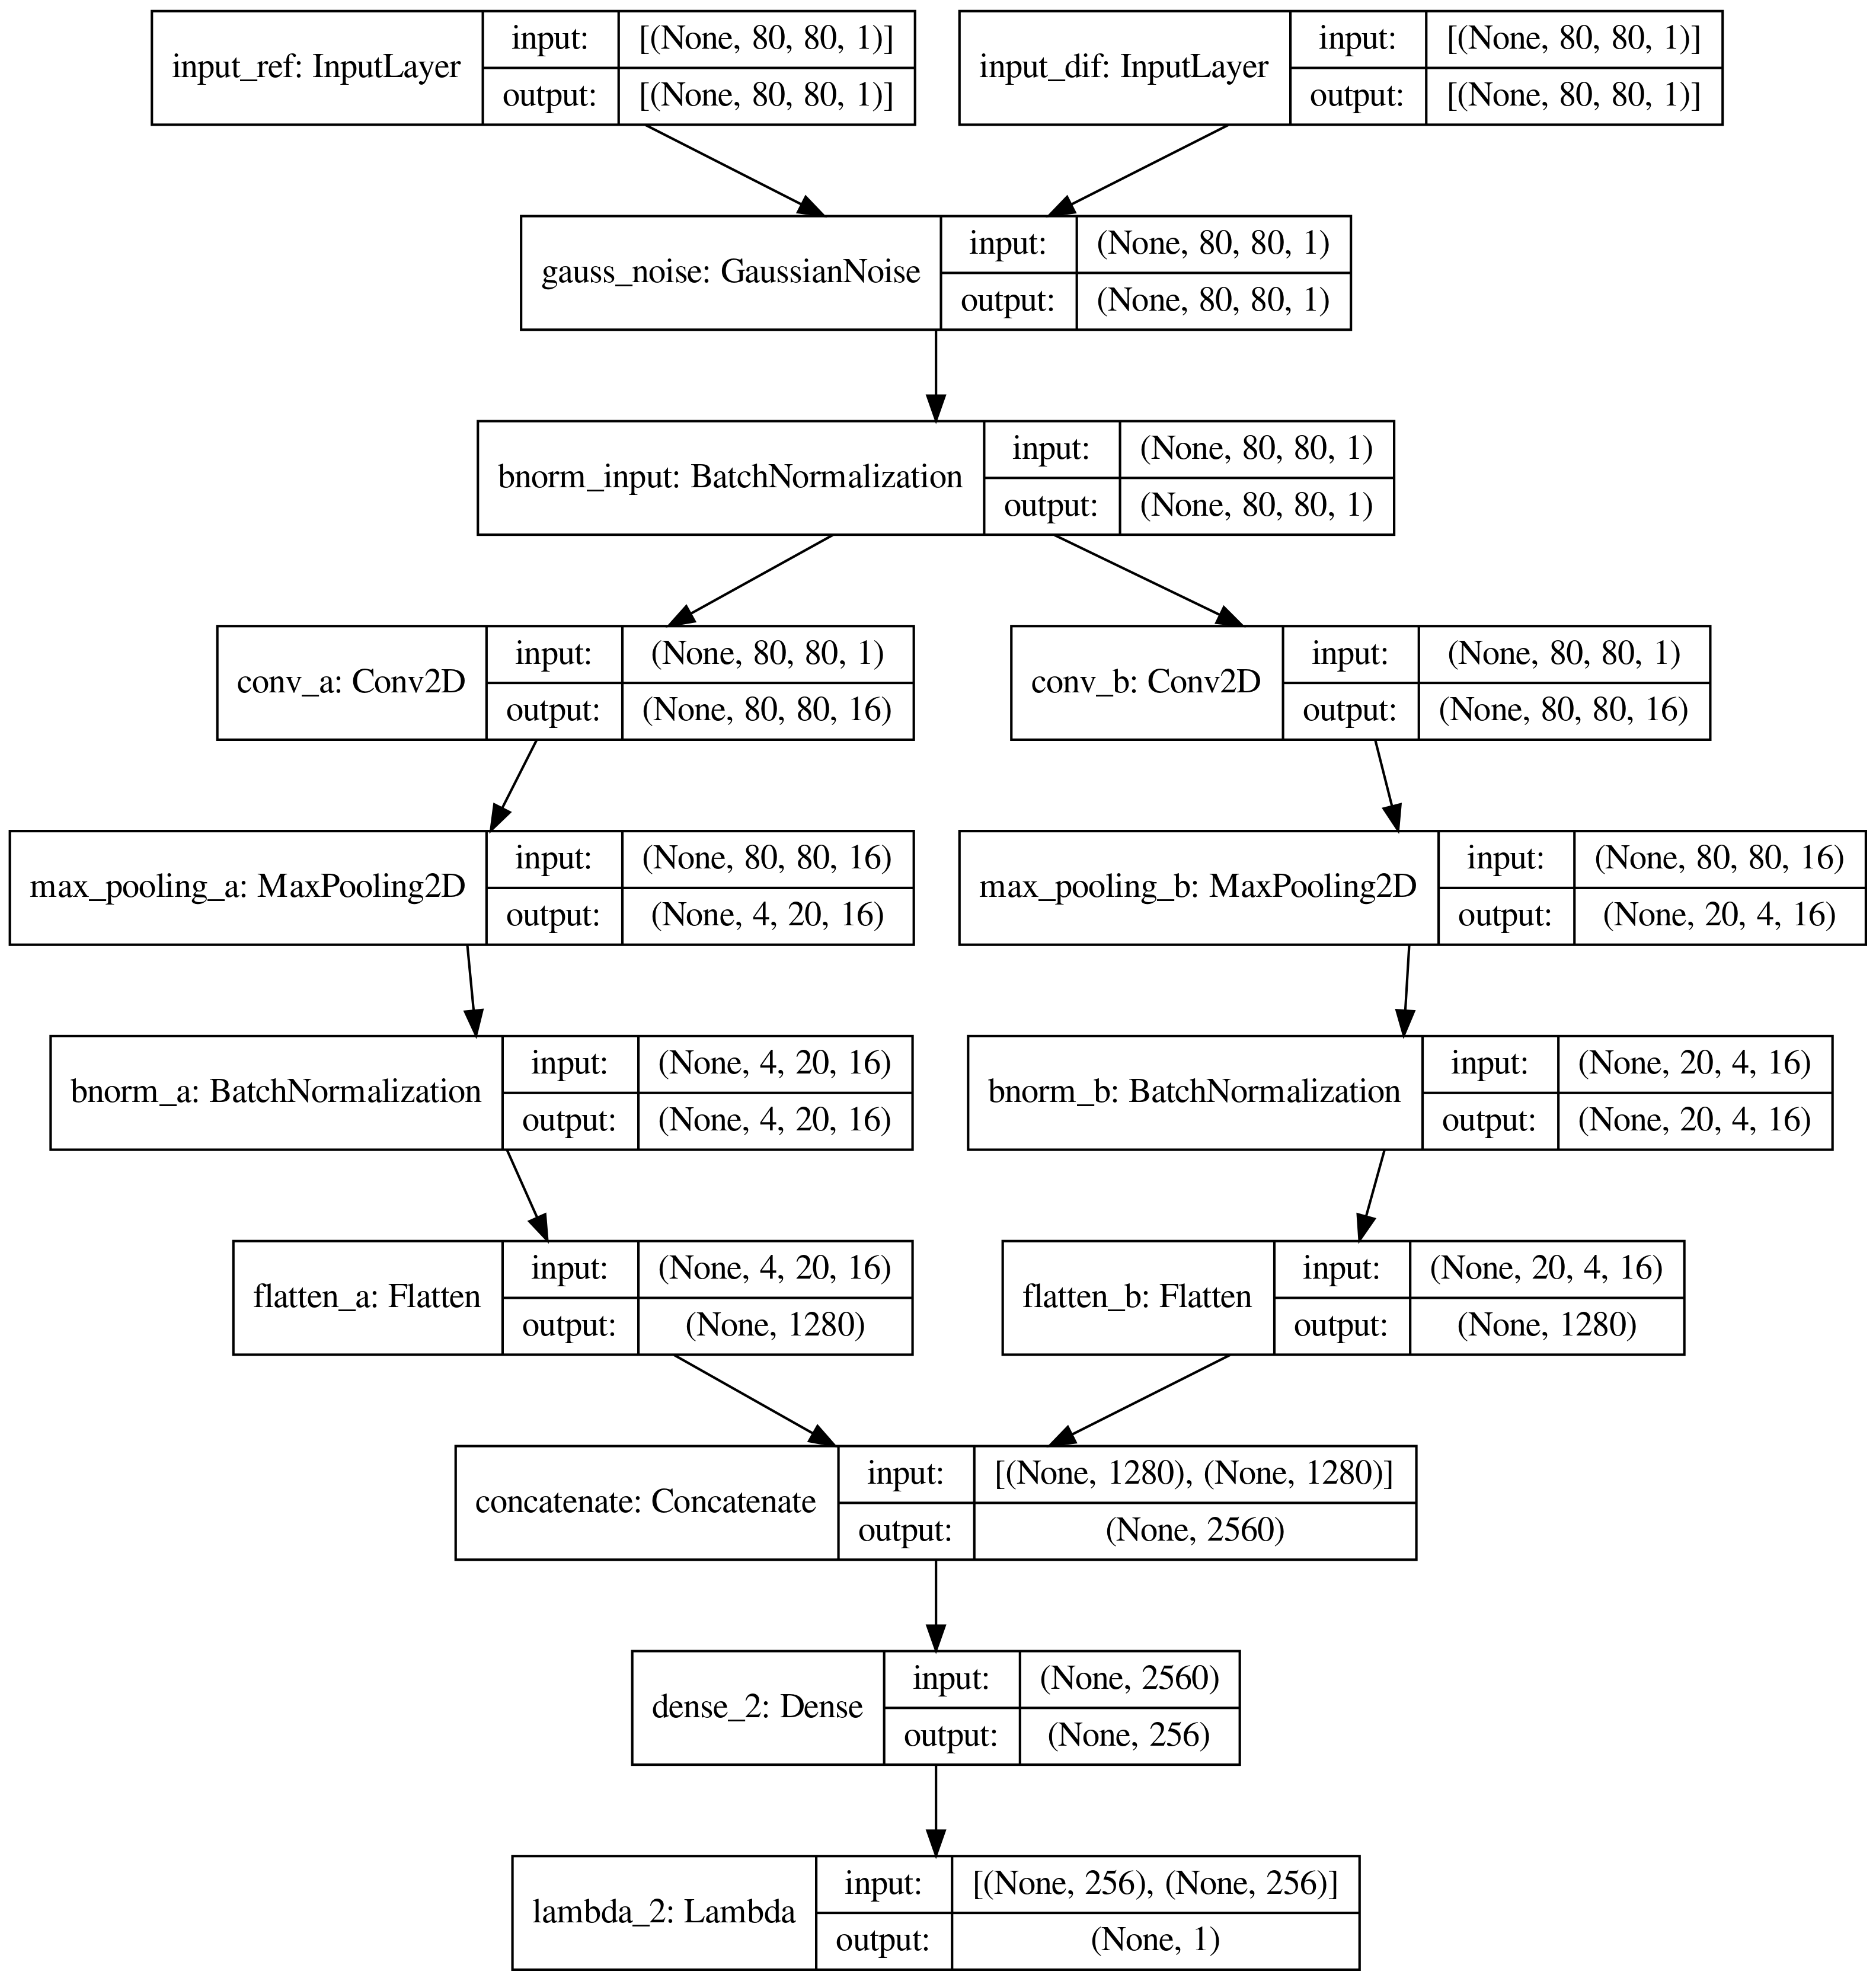

In [75]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='../../images/013_Siamese_Networks_model.png', show_shapes=True, show_layer_names=True, dpi=300)

### Create Data-Pairs

Now we have to prepare and partition the input data. Because it is a **pair-wise comparison approach**, we have to create pairs of input instances with sequentially one row containing the reference track and a similar example and the consecutive row containing the reference track and a dissimilar example.

In [76]:
def create_pairs(feature_data, metadata, labels, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
        
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for _ in range(num_triplets_per_track):
            
            label_diff = np.abs(labels - labels.loc[row_id]).sum(axis=1)
            
            similar_instances    = label_diff[label_diff == 0]
            dissimilar_instances = label_diff[label_diff != 0] 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_instances.sample(1).index.values[0]
            neg_example_idx      = dissimilar_instances.sample(1).index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id
            
            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            gt_labels.append(1)
            
            # impostor pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            gt_labels.append(0)

    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

#### EXPLICACION DE LA FUNCION `create_pairs`

In [77]:
labels = label_metadata
labels

,classical,country,jazz,pop,rock,techno,blues,dance
19072,0,0,0,0,1,0,0,0
17487,1,0,0,0,0,0,0,0
15668,0,0,0,0,1,0,0,0
11610,1,0,0,0,0,0,0,0
17489,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
13597,1,0,0,0,0,0,0,0
9433,1,0,0,0,0,0,0,0
2579,0,0,1,0,0,0,0,0
15587,0,0,0,0,0,1,0,0


In [78]:
row_id = 19072
labels_diff = np.abs(labels - labels.loc[row_id])
labels_diff 

,classical,country,jazz,pop,rock,techno,blues,dance
19072,0,0,0,0,0,0,0,0
17487,1,0,0,0,1,0,0,0
15668,0,0,0,0,0,0,0,0
11610,1,0,0,0,1,0,0,0
17489,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
13597,1,0,0,0,1,0,0,0
9433,1,0,0,0,1,0,0,0
2579,0,0,1,0,1,0,0,0
15587,0,0,0,0,1,1,0,0


In [79]:
label_diff = labels_diff.sum(axis=1)
label_diff

19072    0
17487    2
15668    0
11610    2
17489    2
        ..
13597    2
9433     2
2579     2
15587    2
19000    2
Length: 1998, dtype: int64

In [80]:
similar_instances = label_diff[label_diff == 0]
similar_instances

19072    0
15668    0
5153     0
17495    0
7417     0
        ..
17890    0
24427    0
14780    0
13537    0
17363    0
Length: 379, dtype: int64

In [81]:
dissimilar_instances = label_diff[label_diff != 0]
dissimilar_instances

17487    2
11610    2
17489    2
2689     2
17491    2
        ..
13597    2
9433     2
2579     2
15587    2
19000    2
Length: 1619, dtype: int64

In [82]:
# search a similar random sample
pos_example_idx = similar_instances.sample(1).index.values[0]
pos_example_idx

5993

In [83]:
# search a dissimilar random sample
neg_example_idx = dissimilar_instances.sample(1).index.values[0]
neg_example_idx

20130

In [84]:
# create a feature triplet
feat_id_ref = metadata.loc[row_id].featurespace_id
feat_id_pos = metadata.loc[pos_example_idx].featurespace_id
feat_id_neg = metadata.loc[neg_example_idx].featurespace_id
feat_id_ref, feat_id_pos, feat_id_neg

(0, 677, 1469)

In [85]:
feature_data = melspecs
data_ref  = []
data_dif  = []
gt_labels = []

# positive data pair + paired label --> one row
data_ref.append(feature_data[feat_id_ref])
data_dif.append(feature_data[feat_id_pos])
gt_labels.append(1)

# negative data pair + paired label --> consecutive row
data_ref.append(feature_data[feat_id_ref])
data_dif.append(feature_data[feat_id_neg])
gt_labels.append(0)

# data pair --> CASE row_id=19072, num_triplets_per_track=1
data_pairs = [np.asarray(data_ref), np.asarray(data_dif)]

In [86]:
feature_data.shape

(1998, 80, 80, 1)

In [87]:
np.shape(data_ref)

(2, 80, 80, 1)

In [88]:
np.shape(data_dif)

(2, 80, 80, 1)

In [89]:
np.shape(gt_labels)

(2,)

In [90]:
np.shape(data_pairs)

(2, 2, 80, 80, 1)

#### EXECUTE THE FUNCTION `create_pairs`

In [91]:
data_pairs, paired_labels = create_pairs(melspecs, metadata, label_metadata, 5)

100% (1998 of 1998) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


In [92]:
# check - how many instances have we created? --> 2*5*1998
print(np.shape(data_pairs))
print(np.shape(paired_labels))

(2, 19980, 80, 80, 1)
(19980,)


### Prepare the Siamese Neural Network

In [93]:
# define the model
model_orig = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model_orig.compile(loss=contrastive_loss, optimizer=opt)

Try casting the input data and labels to `float32`:

In [94]:
data_pairs[0].dtype

dtype('float32')

In [95]:
paired_labels.dtype

dtype('int64')

In [96]:
paired_labels = paired_labels.astype(np.float32)
paired_labels.dtype

dtype('float32')

### Train the Siamese Neural Network

In [97]:
# Input data --> list of arrays 
train_set = [data_pairs[0][:-2000], data_pairs[1][:-2000]]

# Target data
train_classes = paired_labels[:-2000]

# Data on which to evaluate the loss at the end of each epoch
vali_data = ([data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:])

# fit the model
model_orig.fit(train_set, train_classes, batch_size=64, verbose=1, epochs=10, shuffle=False, validation_data=vali_data);

Epoch 1/10
281/281 [==============================] - 539s 2s/step - loss: 36.0768 - val_loss: 5.1846
Epoch 2/10
281/281 [==============================] - 498s 2s/step - loss: 3.6978 - val_loss: 1.8926
Epoch 3/10
281/281 [==============================] - 525s 2s/step - loss: 1.3436 - val_loss: 1.0043
Epoch 4/10
281/281 [==============================] - 505s 2s/step - loss: 0.7473 - val_loss: 0.6832
Epoch 5/10
281/281 [==============================] - 492s 2s/step - loss: 0.5268 - val_loss: 0.5391
Epoch 6/10
281/281 [==============================] - 487s 2s/step - loss: 0.4281 - val_loss: 0.4646
Epoch 7/10
281/281 [==============================] - 518s 2s/step - loss: 0.3812 - val_loss: 0.4208
Epoch 8/10
281/281 [==============================] - 533s 2s/step - loss: 0.3427 - val_loss: 0.3927
Epoch 9/10
281/281 [==============================] - 551s 2s/step - loss: 0.3243 - val_loss: 0.3720
Epoch 10/10
281/281 [==============================] - 545s 2s/step - loss: 0.3083 - val_l

Save model weights:

In [98]:
model_orig.save_weights('../../models/013_Siamese_Network.h5')

**NOTA:** Keras model can be saved [during and after training](https://androidkt.com/how-to-save-and-load-model-weights-in-keras/). Using a saved model we can resume training where it left off and avoid long training times, or we can share the model so others can recreate the work. Let’s load the weights from the `.h5` file:

In [99]:
model_orig.load_weights('../../models/013_Siamese_Network.h5')

### Evaluate

Now that we have a trained model, we want to evaluate its performance. The following function calculates the distances between a given query track and all other tracks of the collection. The result is a list of distances where the smallest distance corresponds to the most similar track. The list is sorted in ascending order and the top-ten similar tracks are presented below the information of the query track. 

In [100]:
def similar(model, query_idx):

    ref_cols = ['artist','title','album']
    print(metadata.iloc[query_idx][ref_cols])
    
    feat_idx = metadata.iloc[query_idx].featurespace_id
    
    # given query track
    ref_feat = melspecs[feat_idx]
    
    # add track-dimension to ref_feat
    ref_feat1 = np.expand_dims(ref_feat, 0)
    
    # repeat matrix values along track-dimension --> 1998 repetitions for each element
    nrep = melspecs.shape[0]
    ref_feat2 = np.repeat(ref_feat1, nrep, axis=0)
    
    # calculate predicted distances between query track and all others
    res = model.predict([ref_feat2, melspecs])

    # reshape
    res = res.flatten()
    
    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ['artist','title','album','player']
    
    return HTML(metadata.set_index('featurespace_id').loc[si[:11]][display_cols].to_html(escape=False))

#### EXPLICACION DE LA FUNCION `similar`

In [101]:
query_idx = 2 # given query track index
ref_cols = ['artist','title','album']
print(metadata.iloc[query_idx][ref_cols])

artist    Rocket City Riot            
title     -All I Got-                 
album     Last Of The Pleasure Seekers
Name: 15668, dtype: object


In [102]:
feat_idx = metadata.iloc[query_idx].featurespace_id
feat_idx

2

In [103]:
print(melspecs.shape)

# given query track
ref_feat = melspecs[feat_idx]
print(ref_feat.shape)

# add track-dimension to ref_feat
ref_feat1 = np.expand_dims(ref_feat, 0)
print(ref_feat1.shape)

# repeat matrix values along track-dimension --> 1998 repetitions for each element
nrep = melspecs.shape[0]
ref_feat2 = np.repeat(ref_feat1, nrep, axis=0)
print(ref_feat2.shape)

(1998, 80, 80, 1)
(80, 80, 1)
(1, 80, 80, 1)
(1998, 80, 80, 1)


In [104]:
# calculate predicted distances between query track and all others
res = model_orig.predict([ref_feat2, melspecs])
print(res.shape)

# reshape
res = res.flatten()
print(res.shape)

# get sorted indexes in ascending order (smallest distance to query track first)
si = np.argsort(res)
print(si)

(1998, 1)
(1998,)
[   2  411  761 ...  572 1837 1983]


In [105]:
# output filter
display_cols = ['artist','title','album','player']

# use Jupyter display functions to enable HTML5 audio in pandas dataframe
HTML(metadata.set_index('featurespace_id').loc[si[:11]][display_cols].to_html(escape=False))

,artist,title,album,player
featurespace_id,,,,
2,Rocket City Riot,-All I Got-,Last Of The Pleasure Seekers,
411,Electric Frankenstein,Deal With It,Conquers The World,
761,Hybris,If We Descended,The First Words,
1113,Electric Frankenstein,Out there (F-Word),Sick Songs,
1581,The Wretch,Spinal rape,Ambulatory,
1712,Electric Frankenstein,Teenage Shutdown,The Time Is Now,
109,The West Exit,All right now,Nocturne,
524,MRDC,Evolution,Timecode,
1024,Rocket City Riot,My Baby Loves Me,Middle Age Suicide,


#### EXECUTE THE FUNCTION `similar`
Now let's check the results for some individual tracks by supplying the index to our dataset:

In [106]:
similar(model_orig, 2)

artist    Rocket City Riot            
title     -All I Got-                 
album     Last Of The Pleasure Seekers
Name: 15668, dtype: object


,artist,title,album,player
featurespace_id,,,,
2,Rocket City Riot,-All I Got-,Last Of The Pleasure Seekers,
411,Electric Frankenstein,Deal With It,Conquers The World,
761,Hybris,If We Descended,The First Words,
1113,Electric Frankenstein,Out there (F-Word),Sick Songs,
1581,The Wretch,Spinal rape,Ambulatory,
1712,Electric Frankenstein,Teenage Shutdown,The Time Is Now,
109,The West Exit,All right now,Nocturne,
524,MRDC,Evolution,Timecode,
1024,Rocket City Riot,My Baby Loves Me,Middle Age Suicide,


## Improve Performance through prior Knowledge

The original approach only uses *genuine* and *impostor* pairs and does not consider any further prior knowledge. In that sense if two tracks belong to the same playlist, they are considered similar, if not, they are not. But, because we have chosen genre-playlists, there are genres that are more similar than others. This is of course highly subjective and depends on the listening behaviour and experience of a listener.

The following list represents a possible interpretation of genre similarities:

In [107]:
sim = [[["blues",      "blues"],     1.0],
       [["blues",      "classical"], 0.0],
       [["blues",      "country"],   0.8],
       [["blues",      "jazz"],      0.3],
       [["blues",      "pop"],       0.0],
       [["blues",      "rock"],      0.1],
       [["blues",      "techno"],    0.0],
       [["classical",  "classical"], 1.0],
       [["classical",  "country"],   0.0],
       [["classical",  "jazz"],      0.0],
       [["classical",  "pop"],       0.0],
       [["classical",  "rock"],      0.0],
       [["classical",  "techno"],    0.0],
       [["country",    "country"],   1.0],
       [["country",    "jazz"],      0.1],
       [["country",    "pop"],       0.2],
       [["country",    "rock"],      0.3],
       [["country",    "techno"],    0.0],
       [["jazz",       "jazz"],      1.0],
       [["jazz",       "pop"],       0.0],
       [["jazz",       "rock"],      0.1],
       [["jazz",       "techno"],    0.0],
       [["pop",        "pop"],       1.0],
       [["pop",        "rock"],      0.2],
       [["pop",        "techno"],    0.8],
       [["rock",       "rock"],      1.0],
       [["rock",       "techno"],    0.0],
       [["techno",     "techno"],    1.0]]

In [108]:
np.shape(sim)

/home/ale/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(28, 2)

The following code creates a symmetric lookup-table from the list above:

In [109]:
# get all playlist-names from our dataset
playlist_names = [pl for pl in labels.columns]

# create the lookup-table
Npl = len(labels.columns)
playlist_similarities = pd.DataFrame(np.zeros((Npl,Npl)), 
                                     index   = playlist_names, 
                                     columns = playlist_names)

# self-similarity
for i in range(Npl):
    for j in range(Npl):
        if i == j:
            playlist_similarities.iloc[i,j] = 1.0

# genre-similarities
for s in sim:
    print(s[0][0],s[0][1],s[1])
    playlist_similarities.loc[s[0][0],s[0][1]] = s[1]
    playlist_similarities.loc[s[0][1],s[0][0]] = s[1]

# show results
playlist_similarities 

blues blues 1.0
blues classical 0.0
blues country 0.8
blues jazz 0.3
blues pop 0.0
blues rock 0.1
blues techno 0.0
classical classical 1.0
classical country 0.0
classical jazz 0.0
classical pop 0.0
classical rock 0.0
classical techno 0.0
country country 1.0
country jazz 0.1
country pop 0.2
country rock 0.3
country techno 0.0
jazz jazz 1.0
jazz pop 0.0
jazz rock 0.1
jazz techno 0.0
pop pop 1.0
pop rock 0.2
pop techno 0.8
rock rock 1.0
rock techno 0.0
techno techno 1.0


,classical,country,jazz,pop,rock,techno,blues,dance
classical,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
country,0.0,1.0,0.1,0.2,0.3,0.0,0.8,0.0
jazz,0.0,0.1,1.0,0.0,0.1,0.0,0.3,0.0
pop,0.0,0.2,0.0,1.0,0.2,0.8,0.0,0.0
rock,0.0,0.3,0.1,0.2,1.0,0.0,0.1,0.0
techno,0.0,0.0,0.0,0.8,0.0,1.0,0.0,0.0
blues,0.0,0.8,0.3,0.0,0.1,0.0,1.0,0.0
dance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Create Data-Pairs with similarities

With this lookup-table we can create more accurate input pairs. Instead of similar/dissimilar (`label=1/0`) we can now apply the supplied similarites.

In [110]:
def create_pairs_with_sims(feature_data, metadata, labels, playlist_similarities, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
        
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for _ in range(num_triplets_per_track):
            
            label_diff = np.abs(labels - labels.loc[row_id]).sum(axis=1)
            
            similar_instances    = label_diff[label_diff == 0]
            dissimilar_instances = label_diff[label_diff != 0] 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_instances.sample(1).index.values[0]
            neg_example_idx      = dissimilar_instances.sample(1).index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id

            # playlist of reference
            play_ref = labels.loc[row_id].idxmax(axis=1)            
            
            # playlist of similar sample
            play_dif_pos = labels.loc[pos_example_idx].idxmax(axis=1) 
            
            # playlist of dissimilar sample
            play_dif_neg = labels.loc[neg_example_idx].idxmax(axis=1)

            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            
            # genre-similarity (lookup-table) between REF and SIMILAR
            label = playlist_similarities.loc[play_ref,play_dif_pos]
            gt_labels.append(label)

            # impostor pair with similarity
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            
            # genre-similarity (lookup-table) between REF and DISSIMILAR
            label = playlist_similarities.loc[play_ref,play_dif_neg]
            gt_labels.append(label)

    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

#### EXPLICACION DE LA FUNCION `create_pairs_with_sims`

In [111]:
labels = label_metadata
labels

,classical,country,jazz,pop,rock,techno,blues,dance
19072,0,0,0,0,1,0,0,0
17487,1,0,0,0,0,0,0,0
15668,0,0,0,0,1,0,0,0
11610,1,0,0,0,0,0,0,0
17489,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
13597,1,0,0,0,0,0,0,0
9433,1,0,0,0,0,0,0,0
2579,0,0,1,0,0,0,0,0
15587,0,0,0,0,0,1,0,0


In [112]:
row_id = 19072
labels_diff = np.abs(labels - labels.loc[row_id])
labels_diff 

,classical,country,jazz,pop,rock,techno,blues,dance
19072,0,0,0,0,0,0,0,0
17487,1,0,0,0,1,0,0,0
15668,0,0,0,0,0,0,0,0
11610,1,0,0,0,1,0,0,0
17489,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
13597,1,0,0,0,1,0,0,0
9433,1,0,0,0,1,0,0,0
2579,0,0,1,0,1,0,0,0
15587,0,0,0,0,1,1,0,0


In [113]:
label_diff = labels_diff.sum(axis=1)
label_diff

19072    0
17487    2
15668    0
11610    2
17489    2
        ..
13597    2
9433     2
2579     2
15587    2
19000    2
Length: 1998, dtype: int64

In [114]:
similar_instances = label_diff[label_diff == 0]
similar_instances

19072    0
15668    0
5153     0
17495    0
7417     0
        ..
17890    0
24427    0
14780    0
13537    0
17363    0
Length: 379, dtype: int64

In [115]:
dissimilar_instances = label_diff[label_diff != 0]
dissimilar_instances

17487    2
11610    2
17489    2
2689     2
17491    2
        ..
13597    2
9433     2
2579     2
15587    2
19000    2
Length: 1619, dtype: int64

In [116]:
# search a similar random sample
pos_example_idx = similar_instances.sample(1).index.values[0]
pos_example_idx

5504

In [117]:
# search a dissimilar random sample
neg_example_idx = dissimilar_instances.sample(1).index.values[0]
neg_example_idx

5053

In [118]:
# create a feature triplet
feat_id_ref = metadata.loc[row_id].featurespace_id
feat_id_pos = metadata.loc[pos_example_idx].featurespace_id
feat_id_neg = metadata.loc[neg_example_idx].featurespace_id
feat_id_ref, feat_id_pos, feat_id_neg

(0, 272, 1926)

In [119]:
feature_data = melspecs
data_ref  = []
data_dif  = []
gt_labels = []

In [120]:
# label of reference
labels.loc[row_id]

classical    0
country      0
jazz         0
pop          0
rock         1
techno       0
blues        0
dance        0
Name: 19072, dtype: int64

In [121]:
# playlist of reference
play_ref = labels.loc[row_id].idxmax(axis=1)
play_ref

'rock'

In [122]:
# playlist of similar sample
play_dif = labels.loc[pos_example_idx].idxmax(axis=1)
play_dif

'rock'

In [123]:
# supplied genre-similarity (lookup-table) between REF and SIMILAR
label = playlist_similarities.loc[play_ref,play_dif]
label

1.0

In [124]:
# positive data pair + paired label --> one row
data_ref.append(feature_data[feat_id_ref])
data_dif.append(feature_data[feat_id_pos])
gt_labels.append(label)

In [125]:
# playlist of dissimilar sample
play_dif = labels.loc[neg_example_idx].idxmax(axis=1)
play_dif

'jazz'

In [126]:
# supplied genre-similarity (lookup-table) between REF and DISSIMILAR
label = playlist_similarities.loc[play_ref,play_dif]
label

0.1

In [127]:
# negative data pair + paired label --> consecutive row
data_ref.append(feature_data[feat_id_ref])
data_dif.append(feature_data[feat_id_neg])
gt_labels.append(label)

# data pair --> CASE row_id=19072, num_triplets_per_track=1
data_pairs = [np.asarray(data_ref), np.asarray(data_dif)]

In [128]:
feature_data.shape

(1998, 80, 80, 1)

In [129]:
np.shape(data_ref)

(2, 80, 80, 1)

In [130]:
np.shape(data_dif)

(2, 80, 80, 1)

In [131]:
np.shape(gt_labels)

(2,)

In [132]:
np.shape(data_pairs)

(2, 2, 80, 80, 1)

#### EXECUTE THE FUNCTION `create_pairs_with_sims`

In [133]:
data_pairs, paired_labels = create_pairs_with_sims(melspecs, metadata, label_metadata, playlist_similarities, 5)

100% (1998 of 1998) |####################| Elapsed Time: 0:00:15 Time:  0:00:15


In [134]:
# check - how many instances have we created? --> 2*5*1998
print(np.shape(data_pairs))
print(np.shape(paired_labels))

(2, 19980, 80, 80, 1)
(19980,)


### Prepare the Siamese Neural Network

In [136]:
# define the model
model_sim = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model_sim.compile(loss=contrastive_loss, optimizer=opt)

Verify same type for input data and labels:

In [137]:
data_pairs[0].dtype

dtype('float32')

In [138]:
paired_labels.dtype

dtype('float64')

In [139]:
paired_labels = paired_labels.astype(np.float32)
paired_labels.dtype

dtype('float32')

### Train the Siamese Neural Network

In [266]:
# Input data --> list of arrays 
train_set = [data_pairs[0][:-2000], data_pairs[1][:-2000]]

# Target data
train_classes = paired_labels[:-2000]

# Data on which to evaluate the loss at the end of each epoch
vali_data = ([data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:])

# fit the model
model_sim.fit(train_set, train_classes, batch_size=64, verbose=1, epochs=10, shuffle=False, validation_data=vali_data);

Epoch 1/10
281/281 [==============================] - 505s 2s/step - loss: 33.1129 - val_loss: 4.3994
Epoch 2/10
281/281 [==============================] - 526s 2s/step - loss: 2.7886 - val_loss: 1.5799
Epoch 3/10
281/281 [==============================] - 531s 2s/step - loss: 1.1255 - val_loss: 0.8538
Epoch 4/10
281/281 [==============================] - 528s 2s/step - loss: 0.7003 - val_loss: 0.6116
Epoch 5/10
281/281 [==============================] - 506s 2s/step - loss: 0.5332 - val_loss: 0.5111
Epoch 6/10
281/281 [==============================] - 513s 2s/step - loss: 0.4564 - val_loss: 0.4526
Epoch 7/10
281/281 [==============================] - 500s 2s/step - loss: 0.4131 - val_loss: 0.4186
Epoch 8/10
281/281 [==============================] - 528s 2s/step - loss: 0.3817 - val_loss: 0.3951
Epoch 9/10
281/281 [==============================] - 516s 2s/step - loss: 0.3621 - val_loss: 0.3775
Epoch 10/10
281/281 [==============================] - 513s 2s/step - loss: 0.3454 - val_l

Save model weights:

In [267]:
model_sim.save_weights('../../models/013_Siamese_Network_with_Similarity.h5')

Let’s load the weights from the `.h5` file:

In [140]:
model_sim.load_weights('../../models/013_Siamese_Network_with_Similarity.h5')

### Evaluate

Now that we have the trained model on the adapted data, we evaluate its performance through the function `similar`. Remember that it calculates the distances between a given query track and all other tracks of the collection. The top-ten similar tracks are presented below the information of the query track. 

Let's check the results for some individual tracks by supplying the index to our dataset:

In [141]:
similar(model_sim, 2)

artist    Rocket City Riot            
title     -All I Got-                 
album     Last Of The Pleasure Seekers
Name: 15668, dtype: object


,artist,title,album,player
featurespace_id,,,,
2,Rocket City Riot,-All I Got-,Last Of The Pleasure Seekers,
489,Magnatune Compilation,Electric Frankenstein_ Teenage Shutdown,High Energy Rock and Roll,
1712,Electric Frankenstein,Teenage Shutdown,The Time Is Now,
1875,Rebel Rebel,Venus Plus X,Explode Into Space,
1038,Electric Frankenstein,New Rage,Conquers The World,
524,MRDC,Evolution,Timecode,
411,Electric Frankenstein,Deal With It,Conquers The World,
226,Rocket City Riot,Blow My Mind,Middle Age Suicide,
893,Electric Frankenstein,Learn to burn,Sick Songs,


## Improve Performance through Identity

So far we have taught the network what is similar and what not, but we have not shown it, what is *identical*. All input pairs created so far missed to pass identical data. In the following step, we will include **identical pairs** into the training instances. To emphasis the identity, only identical pairs will be assigned a label of `1`. Tracks of the same playlist will have a similarity value of `0.9`.

This way, the previous symmetric lookup-table now looks like follows:

In [142]:
playlist_similarities[playlist_similarities == 1] = 0.9
playlist_similarities

,classical,country,jazz,pop,rock,techno,blues,dance
classical,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
country,0.0,0.9,0.1,0.2,0.3,0.0,0.8,0.0
jazz,0.0,0.1,0.9,0.0,0.1,0.0,0.3,0.0
pop,0.0,0.2,0.0,0.9,0.2,0.8,0.0,0.0
rock,0.0,0.3,0.1,0.2,0.9,0.0,0.1,0.0
techno,0.0,0.0,0.0,0.8,0.0,0.9,0.0,0.0
blues,0.0,0.8,0.3,0.0,0.1,0.0,0.9,0.0
dance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9


### Create Data-Pairs with similarities and identity

With this lookup-table we can create more accurate input pairs. We can now apply the supplied similarites.

In [143]:
def create_pairs_with_sims_and_identity(feature_data, metadata, labels, playlist_similarities, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
        
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for j in range(num_triplets_per_track):
            
            label_diff = np.abs(labels - labels.loc[row_id]).sum(axis=1)
            
            similar_instances    = label_diff[label_diff == 0]
            dissimilar_instances = label_diff[label_diff != 0] 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_instances.sample(1).index.values[0]
            neg_example_idx      = dissimilar_instances.sample(1).index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id

            # playlist of reference
            play_ref = labels.loc[row_id].idxmax(axis=1)            
            
            # playlist of similar sample
            play_dif_pos = labels.loc[pos_example_idx].idxmax(axis=1) 
            
            # playlist of dissimilar sample
            play_dif_neg = labels.loc[neg_example_idx].idxmax(axis=1)

            #****************** IDENTITY ****************** 
            if j == 0:
                
                # identical pair
                data_ref.append(feature_data[feat_id_ref])
                data_dif.append(feature_data[feat_id_ref])
                gt_labels.append(1)
                
                # impostor pair with similarity
                data_ref.append(feature_data[feat_id_ref])
                data_dif.append(feature_data[feat_id_neg])
                
                # genre-similarity (lookup-table) between REF and DISSIMILAR
                label = playlist_similarities.loc[play_ref,play_dif_neg]
                gt_labels.append(label)
            #**********************************************    

            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            
            # genre-similarity (lookup-table) between REF and SIMILAR
            label = playlist_similarities.loc[play_ref,play_dif_pos]
            gt_labels.append(label)

            # impostor pair with similarity
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            
            # genre-similarity (lookup-table) between REF and DISSIMILAR
            label = playlist_similarities.loc[play_ref,play_dif_neg]
            gt_labels.append(label)

    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

#### EXECUTE THE FUNCTION `create_pairs_with_sims_and_identity`

In [144]:
data_pairs, paired_labels = create_pairs_with_sims_and_identity(melspecs, metadata, label_metadata, playlist_similarities, 5)

100% (1998 of 1998) |####################| Elapsed Time: 0:00:15 Time:  0:00:15


In [145]:
# check - how many instances have we created? --> 2*(5+1)*1998
print(np.shape(data_pairs))
print(np.shape(paired_labels))

(2, 23976, 80, 80, 1)
(23976,)


### Prepare the Siamese Neural Network

In [147]:
# define the model
model_sim_id = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model_sim_id.compile(loss=contrastive_loss, optimizer=opt)

Verify same type for input data and labels:

In [148]:
data_pairs[0].dtype

dtype('float32')

In [149]:
paired_labels.dtype

dtype('float64')

In [150]:
paired_labels = paired_labels.astype(np.float32)
paired_labels.dtype

dtype('float32')

### Train the Siamese Neural Network

In [151]:
# Input data --> list of arrays 
train_set = [data_pairs[0][:-2000], data_pairs[1][:-2000]]

# Target data
train_classes = paired_labels[:-2000]

# Data on which to evaluate the loss at the end of each epoch
vali_data = ([data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:])

# fit the model
model_sim_id.fit(train_set, train_classes, batch_size=64, verbose=1, epochs=10, shuffle=False, validation_data=vali_data);

Epoch 1/10
344/344 [==============================] - 661s 2s/step - loss: 26.2646 - val_loss: 3.2113
Epoch 2/10
344/344 [==============================] - 679s 2s/step - loss: 1.7928 - val_loss: 1.2375
Epoch 3/10
344/344 [==============================] - 656s 2s/step - loss: 0.7213 - val_loss: 0.7152
Epoch 4/10
344/344 [==============================] - 634s 2s/step - loss: 0.4827 - val_loss: 0.5305
Epoch 5/10
344/344 [==============================] - 640s 2s/step - loss: 0.3965 - val_loss: 0.4530
Epoch 6/10
344/344 [==============================] - 647s 2s/step - loss: 0.3588 - val_loss: 0.4082
Epoch 7/10
344/344 [==============================] - 645s 2s/step - loss: 0.3332 - val_loss: 0.3786
Epoch 8/10
344/344 [==============================] - 614s 2s/step - loss: 0.3142 - val_loss: 0.3525
Epoch 9/10
344/344 [==============================] - 681s 2s/step - loss: 0.2930 - val_loss: 0.3133
Epoch 10/10
344/344 [==============================] - 634s 2s/step - loss: 0.2680 - val_l

Save model weights:

In [152]:
model_sim_id.save_weights('../../models/013_Siamese_Network_with_Similarity_and_Identity.h5')

Let’s load the weights from the `.h5` file:

In [153]:
model_sim_id.load_weights('../../models/013_Siamese_Network_with_Similarity_and_Identity.h5')

### Evaluate

Now that we have the trained model on the adapted data, we evaluate its performance through the function `similar`. Remember that it calculates the distances between a given query track and all other tracks of the collection. The top-ten similar tracks are presented below the information of the query track. 

Let's check the results for some individual tracks by supplying the index to our dataset:

In [154]:
similar(model_sim_id, 2)

artist    Rocket City Riot            
title     -All I Got-                 
album     Last Of The Pleasure Seekers
Name: 15668, dtype: object


,artist,title,album,player
featurespace_id,,,,
2,Rocket City Riot,-All I Got-,Last Of The Pleasure Seekers,
1363,Spinecar,Sanchez,Autophile,
781,Skitzo,Insane Empire,Babblesick,
337,Seismic Anamoly,Code Red Love Is Dead,Ramifications,
848,Skitzo,Kill with a Vengeance,Babblesick,
524,MRDC,Evolution,Timecode,
109,The West Exit,All right now,Nocturne,
421,Electric Frankenstein,Demolition Joyride,The Time Is Now,
1082,SoulPrint,Obscenity,In Spite of it All,
